In [35]:
import os
import sounddevice as sd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import pandas as pd
import math
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [2]:
from music_tools import *

In [3]:
df_train, df_test = load_df()

In [4]:
df_train.head()

,filename,frequency,instrument_family,instrument_family_str,pitch,sample_rate
0,string_acoustic_014-064-127,329.627557,8,string,64,16000
1,keyboard_electronic_001-065-127,349.228231,4,keyboard,65,16000
2,bass_synthetic_034-065-127,349.228231,0,bass,65,16000
3,guitar_acoustic_010-064-100,329.627557,3,guitar,64,16000
4,keyboard_electronic_001-060-075,261.625565,4,keyboard,60,16000


In [5]:
df_train.dtypes

filename                  object
frequency                float64
instrument_family          int64
instrument_family_str     object
pitch                      int64
sample_rate                int64
dtype: object

In [6]:
first_signal_df = df_train.iloc[0, :]
first_signal, sampling_rate_first_signal = load_signal(first_signal_df["filename"])
play_signal(first_signal, sampling_rate_first_signal)

In [7]:
vocal_signals = df_train [df_train["instrument_family_str"] == "vocal"] 
first_vocal_signal_df = vocal_signals.iloc[0, :]
first_vocal_signal_df.head()

filename                 vocal_synthetic_003-067-025
frequency                                    391.995
instrument_family                                 10
instrument_family_str                          vocal
pitch                                             67
Name: 19, dtype: object

In [8]:
first_vocal_signal, sampling_rate_vocal_signal = load_signal(first_vocal_signal_df["filename"])
play_signal(first_vocal_signal, sampling_rate_vocal_signal)

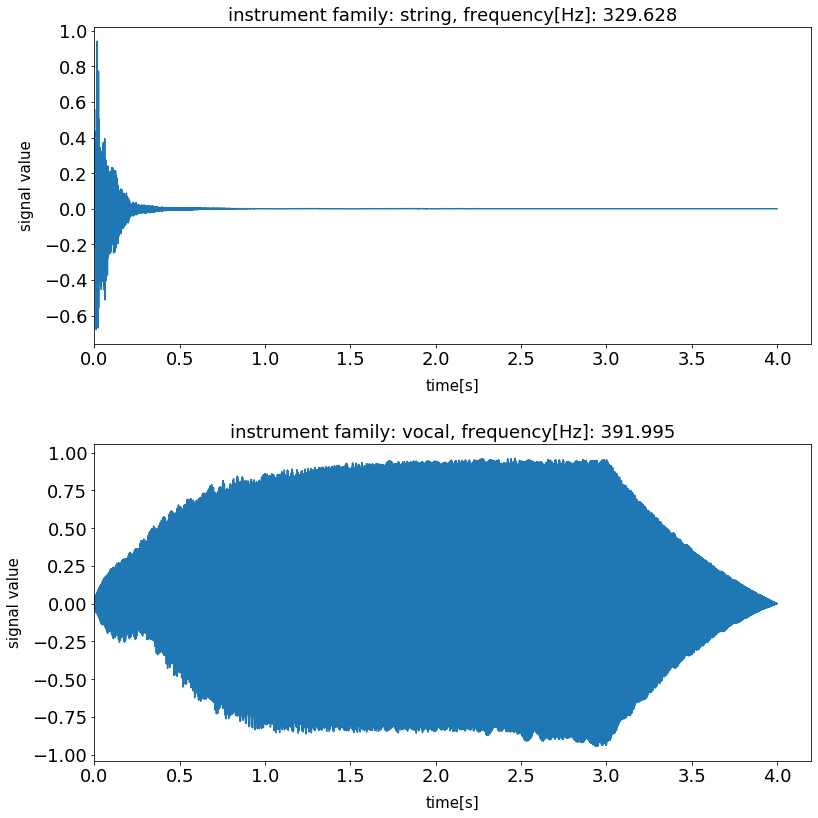

In [9]:
figure = plt.figure(figsize=(12, 12))

plot_a = plt.subplot(211)
time = np.linspace(0, len(first_signal) / sampling_rate_first_signal, num=len(first_signal))
plot_a.plot(time, first_signal)
plot_a.set_xlabel("time[s]", fontsize=15, labelpad=10)
plot_a.set_ylabel("signal value", fontsize=15, labelpad=10)
plt.setp(plot_a.get_xticklabels(), fontsize=18)
plt.setp(plot_a.get_yticklabels(), fontsize=18)
plot_a.set_xlim(xmin=0)

#     plt.legend(fontsize=18)
plot_a.set_title("instrument family: " + first_signal_df["instrument_family_str"] + ", frequency[Hz]: " + 
                 str(round(first_signal_df["frequency"], 3)), fontsize=18)

plot_b = plt.subplot(212)
time = np.linspace(0, len(first_vocal_signal) / sampling_rate_vocal_signal, num=len(first_vocal_signal))
plot_b.plot(time, first_vocal_signal)
plot_b.set_xlabel("time[s]", fontsize=15, labelpad=10)
plot_b.set_ylabel("signal value", fontsize=15, labelpad=10)
plot_b.set_title("instrument family: " + first_vocal_signal_df["instrument_family_str"] + ", frequency[Hz]: " + 
                 str(round(first_vocal_signal_df["frequency"], 3)), fontsize=18)
plt.setp(plot_b.get_xticklabels(), fontsize=18)
plt.setp(plot_b.get_yticklabels(), fontsize=18)
plot_b.set_xlim(xmin=0)

plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
figure.tight_layout(pad=3.0)

plt.savefig("signals.pdf")
plt.show()

In [11]:
W = np.fft.fft([1,2,1,0,1,2,1,0])
W

array([8.+0.j, 0.+0.j, 0.-4.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+4.j, 0.+0.j])

In [12]:
comp_f = list()
for i in range(len(W)):
    f = np.angle(W[i])/ (2 * np.pi)
    comp_f.append(f)

In [13]:
comp_f

[0.0, 0.0, -0.25, 0.0, 0.0, 0.0, 0.25, 0.0]

In [14]:
F = np.fft.fftfreq(len(W))

In [15]:
F

array([ 0.   ,  0.125,  0.25 ,  0.375, -0.5  , -0.375, -0.25 , -0.125])

In [ ]:
#df_test_small = df_test.iloc[:3,:]
# df_test_small = df_test
# signals = load_signals(df_test_small) 
# for i in range(len(df_test_small)):
#     row = df_test_small.iloc[i, :]
#     k = row["frequency"]
#     frate = row["sample_rate"]
#     signal = signals[i,:]
#     imax = np.argmax(np.abs(signal))
#     N = len(signal)
#     freq =(k * imax) / N
#     freq *= frate
#     if row["pitch"] == freq2pitch(freq):
#         print("Got it")
#         print(i, imax, freq, freq2pitch(freq), row["pitch"])

In [57]:
instrument_family_total = df_test.groupby("instrument_family")["instrument_family"].count()
instrument_family_total

instrument_family
0     55
1     36
2     12
3     36
4     61
5     13
6     31
7     18
8     12
10     9
Name: instrument_family, dtype: int64

In [17]:
instrument_family_str  = df_test["instrument_family_str"].unique()
instrument_family_str

array(['guitar', 'keyboard', 'reed', 'string', 'bass', 'brass', 'organ',
       'flute', 'vocal', 'mallet'], dtype=object)

In [120]:
signals = load_signals(df_test) 
predicted_pitches = list()
bad_prediction_count = 1
uncorrect_predicted_signals = list()
c = Counter()
for i in range(len(df_test)):
    row = df_test.iloc[i, :]
    k = row["frequency"]
    frate = row["sample_rate"]
    instrument_family = row["instrument_family"]
    signal = signals[i,:]
    w = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(w), 1/frate)    
    imax = np.argmax(np.abs(w))
    freq = freqs[imax]
    #freq_in_hertz = freq * frate
    if freq ==0:
        print(f"Invalid freq., i:{i}, freq:{freq}")
        continue
    if row["pitch"] == freq2pitch(freq):
        predicted_pitches.append(freq2pitch(freq))
        #print("Good: {}, {}, {}, {}, {}".format(i, row["pitch"], row["frequency"], freq, freq2pitch(freq)))
    else:
        c[instrument_family] += 1
        uncorrect_predicted_signals.append((freq, signal))
        #print(i, row["pitch"], row["frequency"], freq, freq2pitch(freq))

Invalid freq., i:278, freq:0.0


In [121]:
len(predicted_pitches)/len(df_test)

0.7208480565371025

In [122]:
print(c)

Counter({0: 22, 1: 16, 4: 13, 7: 10, 6: 7, 10: 6, 3: 2, 8: 1, 5: 1})


In [123]:
ratios = list()
for index, value in instrument_family_total.items():
    print(f"family:{index}, total:{value}, misclassified:{c[index]}, incorrect prediction ratio:{c[index]/value}")
    ratios.append(c[index]/value)

family:0, total:55, misclassified:22, incorrect prediction ratio:0.4
family:1, total:36, misclassified:16, incorrect prediction ratio:0.4444444444444444
family:2, total:12, misclassified:0, incorrect prediction ratio:0.0
family:3, total:36, misclassified:2, incorrect prediction ratio:0.05555555555555555
family:4, total:61, misclassified:13, incorrect prediction ratio:0.21311475409836064
family:5, total:13, misclassified:1, incorrect prediction ratio:0.07692307692307693
family:6, total:31, misclassified:7, incorrect prediction ratio:0.22580645161290322
family:7, total:18, misclassified:10, incorrect prediction ratio:0.5555555555555556
family:8, total:12, misclassified:1, incorrect prediction ratio:0.08333333333333333
family:10, total:9, misclassified:6, incorrect prediction ratio:0.6666666666666666


In [124]:
ratios.sort(reverse=True)
ratios

[0.6666666666666666,
 0.5555555555555556,
 0.4444444444444444,
 0.4,
 0.22580645161290322,
 0.21311475409836064,
 0.08333333333333333,
 0.07692307692307693,
 0.05555555555555555,
 0.0]

In [125]:
instr_family_10 = df_test[df_test["instrument_family"] == 10]

In [126]:
instr_family_10.head(10)

,filename,frequency,instrument_family,instrument_family_str,pitch,sample_rate
1026,vocal_synthetic_003-060-050,261.625565,10,vocal,60,16000
1071,vocal_synthetic_003-067-050,391.995436,10,vocal,67,16000
1160,vocal_acoustic_000-062-050,293.664768,10,vocal,62,16000
1168,vocal_synthetic_003-064-100,329.627557,10,vocal,64,16000
1192,vocal_synthetic_003-069-100,440.000000,10,vocal,69,16000
1216,vocal_synthetic_003-064-075,329.627557,10,vocal,64,16000
1248,vocal_synthetic_003-065-025,349.228231,10,vocal,65,16000
1249,vocal_synthetic_003-069-127,440.000000,10,vocal,69,16000
1278,vocal_synthetic_003-072-127,523.251131,10,vocal,72,16000


In [28]:
# df_test_small = df_test
# signals = load_signals(df_test_small) 
# predicted_pitches = list()
# for i in range(len(df_test_small)):
#     row = df_test_small.iloc[i, :]
#     k = row["frequency"]
#     frate = row["sample_rate"]
#     signal = signals[i,:]
#     w = np.fft.fft(signal)    
#     imax = np.argmax(np.abs(w))
#     w_max = w[imax]
#     freq = np.angle(w_max)
#     freq /= 2 * np.pi
#     freq_in_hertz = abs(freq * frate)
#     if freq_in_hertz <1:
#         print(freq)
#         continue
#     if row["pitch"] == freq2pitch(freq_in_hertz):
#         predicted_pitches.append(freq2pitch(freq_in_hertz))
#     else:
#         pass

In [29]:
def get_coefficients_freqs(index_signal: int, uncorrect_predicted_signals, data: pd.DataFrame, index_data: int, ):
    signal = uncorrect_predicted_signals[index_signal][1]
    w = np.fft.fft(signal)
    row = data.iloc[index_data, :]
    frate = row["sample_rate"]
    freqs = np.fft.fftfreq(len(w), 1/frate)   
    return w, freqs

In [30]:
# signal_a = uncorrect_predicted_signals[0]
# row_a = df_test.iloc[1, :]
# frate_a = row_a["sample_rate"]
# w_a = np.fft.fft(signal_a)
# freqs_a = np.fft.fftfreq(len(w_a), 1/frate_a)    
#print(w, freqs)

In [31]:
# signal_b = uncorrect_predicted_signals[1]
# row_b = df_test.iloc[2, :]
# frate_b = row_b["sample_rate"]
# w_b = np.fft.fft(signal_b)
# freqs_b = np.fft.fftfreq(len(w_b), 1/frate_b)    

In [32]:
# from scipy import fftpack
# W = fftpack.fft(first_non_predicted_signal)
# Freqs = fftpack.fftfreq(len(first_non_predicted_signal)) * frate
# print(W, Freqs)

In [33]:
def plot_signals(uncorrect_predicted_signals, data: pd.DataFrame):
    figure = plt.figure(figsize=(12, 12))

    plot_a = plt.subplot(211)
    signal_a_index = 1
    w_a, freqs_a = get_coefficients_freqs(0, uncorrect_predicted_signals, data, signal_a_index)
    plot_a.plot(freqs_a, np.abs(w_a))
    plot_a.set_xlabel("Frequency in Hertz [Hz]", fontsize=15, labelpad=10)
    plot_a.set_ylabel("Magnitude", fontsize=15, labelpad=10)
    plt.setp(plot_a.get_xticklabels(), fontsize=18)
    plt.setp(plot_a.get_yticklabels(), fontsize=18)
    frate_a = data.iloc[signal_a_index, :]["sample_rate"]
    plot_a.set_xlim(-frate_a / 2, frate_a / 2)
    #plot_a.set_xlim(xmin=0)
    first_signal_df = data.iloc[signal_a_index, :]
    plot_a.set_title("Instrument family: " + first_signal_df["instrument_family_str"] + "\n true frequency[Hz]: " + 
                     str(round(first_signal_df["frequency"], 3)) + ", predicted frequency[Hz]: " + 
                     str(round(uncorrect_predicted_signals[0][0], 3)), fontsize=18, horizontalalignment="center")

    plot_b = plt.subplot(212)
    signal_b_index = 1
    w_b, freqs_b = get_coefficients_freqs(1, uncorrect_predicted_signals, data, signal_b_index)
    plot_b.plot(freqs_b, np.abs(w_b))
    plot_b.set_xlabel("Frequency in Hertz [Hz]", fontsize=15, labelpad=10)
    plot_b.set_ylabel("Absolute value DFT coefficients", fontsize=15, labelpad=10)
    plt.setp(plot_b.get_xticklabels(), fontsize=18)
    plt.setp(plot_b.get_yticklabels(), fontsize=18)
    frate_b = data.iloc[signal_b_index, :]["sample_rate"]
    plot_b.set_xlim(-frate_b / 2, frate_b / 2)
    second_signal_df = data.iloc[signal_b_index, :]
    plot_b.set_title("Instrument family: " + second_signal_df["instrument_family_str"] + "\n true frequency[Hz]: " + 
                     str(round(second_signal_df["frequency"], 3)) + ", predicted frequency[Hz]: " + 
                     str(round(uncorrect_predicted_signals[1][0], 3)), fontsize=18, horizontalalignment="center")

    plt.gcf().subplots_adjust(bottom=0.3)
    plt.gcf().subplots_adjust(left=0.3)
    figure.tight_layout(pad=3.0)

    plt.savefig("misclassified_signals.pdf")
    plt.show()

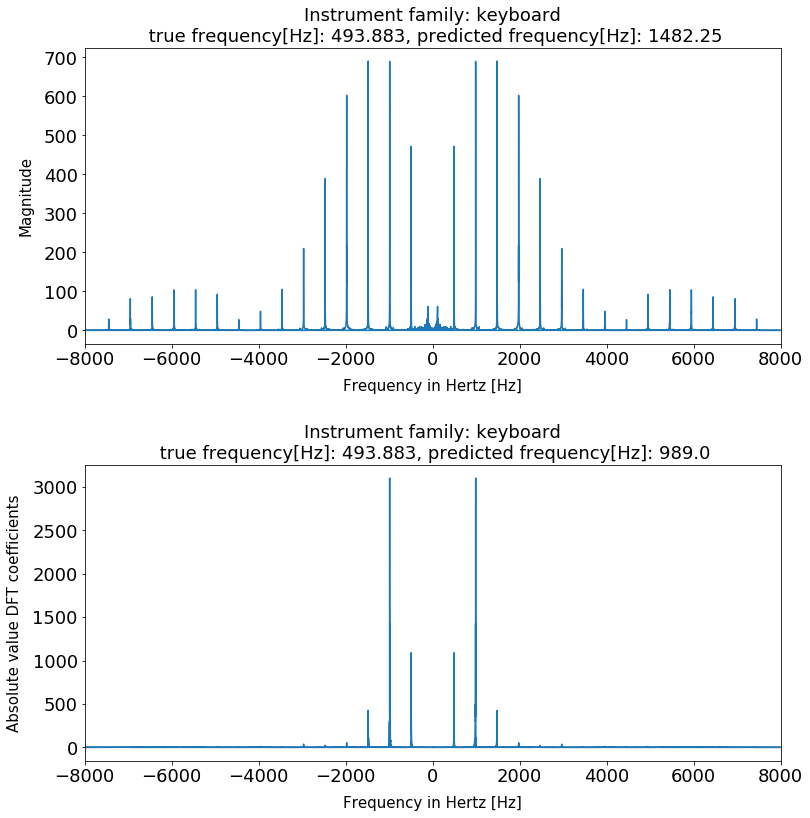

In [34]:
plot_signals(uncorrect_predicted_signals, df_test)

In [59]:
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", fit_intercept=False)

In [85]:
def load_data(data):
    pitches = list()
    signals = load_signals(data) 
    X = list()
    y = list()
    for i in range(len(data)):
        row = data.iloc[i, :]
        pitch = row["pitch"]
        pitches.append(pitch)
        y.append(pitch)
        signal = signals[i,:]
        w = np.fft.fft(signal)
        X.append(np.abs(w))
    X = np.array(X)
    y = np.array(y)
    print(X.shape, y.shape) 
    return X, y, pitches

In [86]:
X_train, y_train, _ = load_data(df_train)

(1000, 64000) (1000,)


In [87]:
model.fit(X, y)

/Users/yg/anaconda3/envs/mathds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
X_test, y_test, pitches = load_data(df_test)

(283, 64000) (283,)


In [89]:
y_predict = model.predict(X_test)

In [90]:
score = model.score(X_test, y_test)
print(score)

0.9964664310954063


In [91]:
model_coeff = model.coef_

In [94]:
#pitches[:20]

In [97]:
model_coeff[0,:]

array([-5.53310077e-04, -1.73661897e-04, -5.90492385e-05, ...,
       -9.27863737e-06, -5.90492385e-05, -1.73661897e-04])

In [96]:
test_pitches  = df_test["pitch"].unique()
test_pitches

array([71, 64, 72, 60, 67, 69, 65, 62])

In [105]:
def get_freqs(index_pitch: int, model_coeff, pitches):
    pitch = pitches[index_pitch]
    print(f"Pitch:{pitch}")
    w = model_coeff[index_pitch, :]
    frate = pitch2freq(pitch)
    print(f"frate:{frate}")
    freqs = np.fft.fftfreq(len(w), 1/frate)   
    return w, freqs, frate

In [99]:
w_a, freqs_a = get_freqs(3,model_coeff,  test_pitches)

Pitch:60
frate:261.6255653005986


In [117]:
def plot_classification(model, data: pd.DataFrame):
    figure = plt.figure(figsize=(12, 20))

    model_coeff = model.coef_
    test_pitches  = df_test["pitch"].unique()

    plot_a = plt.subplot(311)
    pitch_index_60 = 3
    w_a, freqs_a, frate_a = get_freqs(pitch_index_60, model_coeff, test_pitches)
    plot_a.plot(freqs_a, np.abs(w_a))
    plot_a.set_xlabel("Frequency in Hertz [Hz]", fontsize=15, labelpad=10)
    plot_a.set_ylabel("Magnitude", fontsize=15, labelpad=10)
    plt.setp(plot_a.get_xticklabels(), fontsize=18)
    plt.setp(plot_a.get_yticklabels(), fontsize=18)
    plot_a.set_xlim(-frate_a / 2, frate_a / 2)
    plot_a.set_title(f"Pitch:{test_pitches[pitch_index_60]}")

    plot_b = plt.subplot(312)
    pitch_index_65 = 6
    w_b, freqs_b, frate_b = get_freqs(pitch_index_65, model_coeff, test_pitches)
    plot_b.plot(freqs_b, np.abs(w_b))
    plot_b.set_xlabel("Frequency in Hertz [Hz]", fontsize=15, labelpad=10)
    plot_b.set_ylabel("Magnitude", fontsize=15, labelpad=10)
    plt.setp(plot_b.get_xticklabels(), fontsize=18)
    plt.setp(plot_b.get_yticklabels(), fontsize=18)
    plot_b.set_xlim(-frate_b / 2, frate_b / 2)
    plot_b.set_title(f"Pitch:{test_pitches[pitch_index_65]}")

    plot_c = plt.subplot(313)
    pitch_index_72 = 2
    w_c, freqs_c, frate_c = get_freqs(pitch_index_72, model_coeff, test_pitches)
    plot_c.plot(freqs_c, np.abs(w_c))
    plot_c.set_xlabel("Frequency in Hertz [Hz]", fontsize=15, labelpad=10)
    plot_c.set_ylabel("Magnitude", fontsize=15, labelpad=10)
    plt.setp(plot_c.get_xticklabels(), fontsize=18)
    plt.setp(plot_c.get_yticklabels(), fontsize=18)
    plot_c.set_xlim(-frate_c / 2, frate_c / 2)
    plot_c.set_title(f"Pitch:{test_pitches[pitch_index_72]}")

 
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.gcf().subplots_adjust(left=0.3)
    figure.tight_layout(pad=3.0)

    plt.savefig("pitch_classification.pdf")
    plt.show()

Pitch:60
frate:261.6255653005986
Pitch:65
frate:349.2282314330039
Pitch:72
frate:523.2511306011972


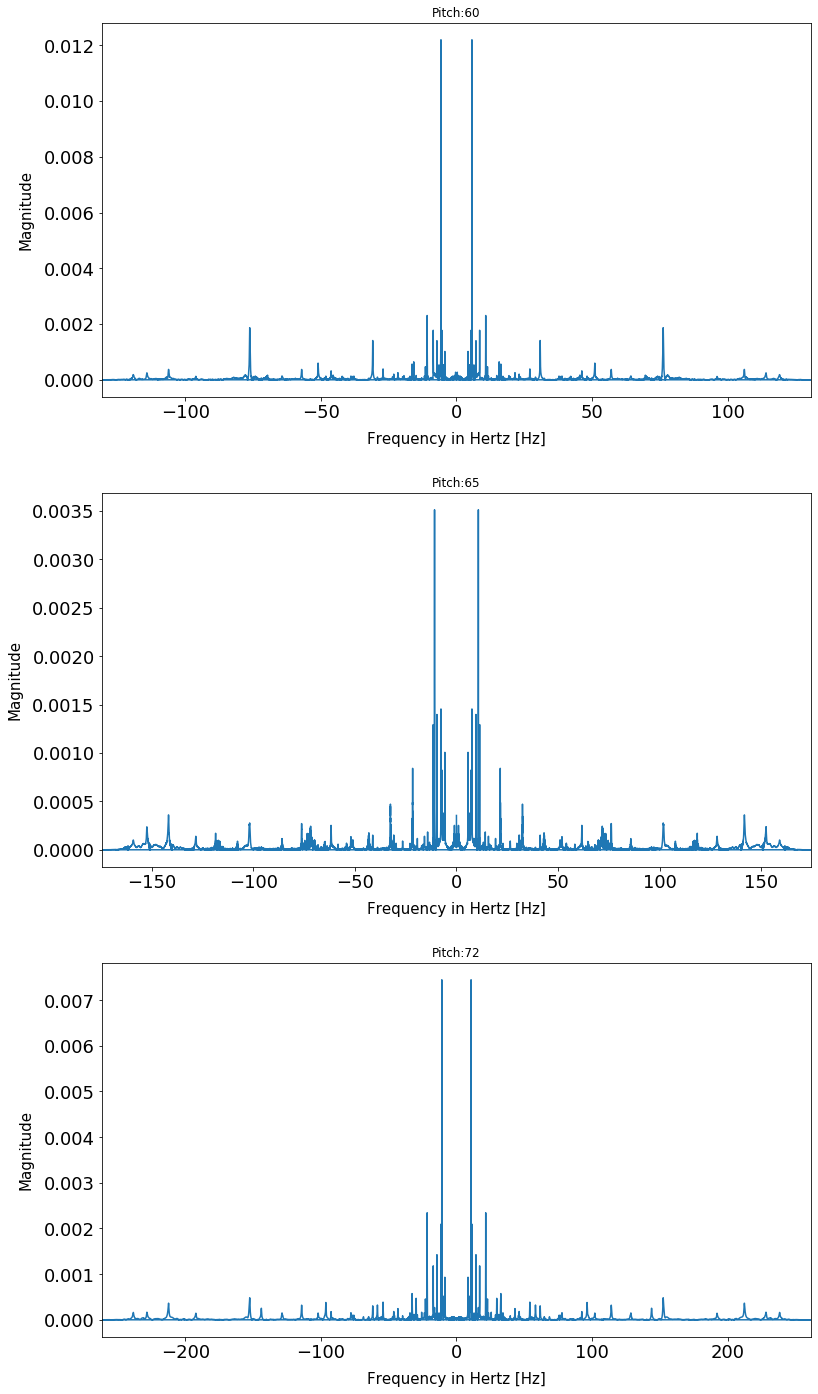

In [118]:
plot_classification(model, df_test)